In [7]:
import re 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

## Load the dataset

In [9]:
train = pd.read_csv('data/train.txt', 
                    header=None, sep=';', 
                    names=['Text', 'Emotion'], 
                    encoding='utf-8')

test = pd.read_csv('data/test.txt', 
                    header=None, sep=';', 
                    names=['Text', 'Emotion'], 
                    encoding='utf-8')

val = pd.read_csv('data/val.txt', 
                    header=None, sep=';', 
                    names=['Text', 'Emotion'], 
                    encoding='utf-8')

In [10]:
train.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Encoding

In [11]:
emotions_to_labels = {'anger': 0, 'love': 1, 'fear': 2, 
                      'joy': 3, 'sadness': 4,'surprise': 5}
train['Label'] = train['Emotion'].replace(emotions_to_labels)
test['Label'] = test['Emotion'].replace(emotions_to_labels)
val['Label'] = val['Emotion'].replace(emotions_to_labels)

In [12]:
train.head()

,Text,Emotion,Label
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,1
4,i am feeling grouchy,anger,0


In [13]:
train.isnull().sum()

Text       0
Emotion    0
Label      0
dtype: int64

In [14]:
train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

## Analyzing the Data

<AxesSubplot:xlabel='Emotion', ylabel='count'>

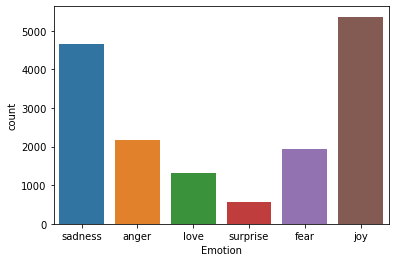

In [15]:
sns.countplot(x='Emotion', data=train)

<AxesSubplot:xlabel='Emotion', ylabel='count'>

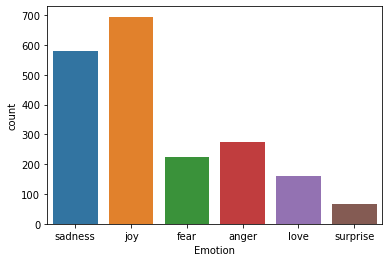

In [16]:
sns.countplot(x='Emotion', data=test)

<AxesSubplot:xlabel='Emotion', ylabel='count'>

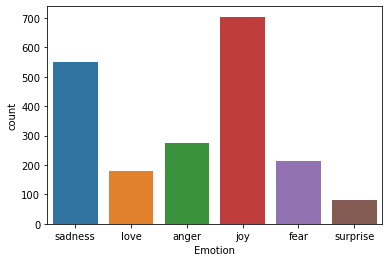

In [17]:
sns.countplot(x='Emotion', data=val)

## Text Preprocessing

In [18]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to C:\Users\Ajay's
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ajay's
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#Accepts a line and returns preprocessed text
def text_preprocess(text, stop_words=False):
    #remove non words from text
    text = re.sub(r'\W+', ' ', text).lower()
    tokens = word_tokenize(text)
    if stop_words:
        tokens = [token for token in tokens if token not in STOPWORDS]
    return tokens

In [20]:
print('Before: ')
print(train.head())

x_train = [text_preprocess(t, stop_words=True) for t in train['Text']]
y_train = train['Label'].values

print('\nAfter:')
for x in list(zip(x_train[:5], y_train[:5])):
    print(x)

Before: 
                                                Text  Emotion  Label
0                            i didnt feel humiliated  sadness      4
1  i can go from feeling so hopeless to so damned...  sadness      4
2   im grabbing a minute to post i feel greedy wrong    anger      0
3  i am ever feeling nostalgic about the fireplac...     love      1
4                               i am feeling grouchy    anger      0

After:
(['didnt', 'feel', 'humiliated'], 4)
(['go', 'feeling', 'hopeless', 'damned', 'hopeful', 'around', 'someone', 'cares', 'awake'], 4)
(['im', 'grabbing', 'minute', 'post', 'feel', 'greedy', 'wrong'], 0)
(['ever', 'feeling', 'nostalgic', 'fireplace', 'know', 'still', 'property'], 1)
(['feeling', 'grouchy'], 0)


In [21]:
x_test = [text_preprocess(t, stop_words=True) for t in test['Text']]
y_test = test['Label'].values

x_val = [text_preprocess(t, stop_words=True) for t in val['Text']]
y_val = val['Label'].values

## Word Embeddings

In [22]:
# load pre-trained model
import gensim.downloader as api
model_wiki = api.load('fasttext-wiki-news-subwords-300')

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [23]:
from gensim.models import Word2Vec

model_w2v = Word2Vec(x_train + x_test + x_val,   # data for model to train on
                 vector_size = 300,              # embedding vector size
                 min_count = 2).wv  

## Vectorization

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
DICT_SIZE = 15000
#max size of columns
tokenizer = Tokenizer(num_words=DICT_SIZE)
total = x_train + x_train + x_val
tokenizer.fit_on_texts(total)

In [26]:
list(tokenizer.word_index.items())[:5]

[('feel', 1), ('feeling', 2), ('like', 3), ('im', 4), ('really', 5)]

In [27]:
len(tokenizer.word_index)

16045

In [28]:
#max length of sentence
x_train_max_len = max([len(i) for i in x_train])
x_test_max_len = max([len(i) for i in x_test])
x_val_max_len = max([len(i) for i in x_val])

MAX_LEN = max(x_train_max_len, x_test_max_len, x_val_max_len)

In [29]:
MAX_LEN

35

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
#change size of vectors to MAX_LEN and pad indexes
X_train = tokenizer.texts_to_sequences(x_train)
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN)

X_test = tokenizer.texts_to_sequences(x_test)
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN)

X_val = tokenizer.texts_to_sequences(x_val)
X_val_pad = pad_sequences(X_val, maxlen=MAX_LEN)

In [32]:
X_train[0]

[51, 1, 556]

In [33]:
X_train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  51,   1, 556])

## Embedding Matrix

In [34]:
def create_weight_matrix(model, second_model=False):
    vector_size = model.get_vector('like').shape[0]
    w_matrix = np.zeros((DICT_SIZE, vector_size))
    skipped_words = []
    for word, index in tokenizer.word_index.items():
        if index < DICT_SIZE:
            if word in model.key_to_index: 
                w_matrix[index] = model.get_vector(word)
            else:
                if second_model:
                    if word in second_model.key_to_index:
                        w_matrix[index] = second_model.get_vector(word)
                    else:
                        skipped_words.append(word)
                else:
                    skipped_words.append(word)
 
    print(f'{len(skipped_words)} words were skipped. Some of them:')
    print(skipped_words[:50])
    return w_matrix

In [35]:
weight_matrix = create_weight_matrix(model_wiki, model_w2v)

991 words were skipped. Some of them:
['jacynthe', 'rupaul', 'kayle', 'gerling', 'mxm', 'dannika', 'hyperchondria', 'manitz', 'educationg', 'gosman', 'montauk', 'bummin', 'wheeeeee', 'underwears', 'olivias', 'bandhu', 'uplifter', 'suicidalness', 'dykey', 'provokingbeauty', 'bodypump', 'honkerblonked', 'clermont', 'instructables', 'janne', 'suominen', 'kamiki', 'nozomi', 'nonchan', 'beaubronz', 'docrat', 'allthingsbucks', 'irresponcible', 'scruncher', 'utf', 'isprivate', 'ismobile', 'mobileclass', 'isprivateblog', 'languagedirection', 'feedlinks', 'lorena', 'handss', 'nervs', 'mommyhood', 'nowwwwww', 'whitleys', 'forelorn', 'baachan', 'covingtons']


In [36]:
weight_matrix.shape

(15000, 300)

## Creating the layers

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [38]:
#early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss',
                     mode='min', verbose=1, patience=3)

In [39]:
# initialize sequential model
model = Sequential()
model.add(Embedding(input_dim = DICT_SIZE, # the whole vocabulary size
                    output_dim = weight_matrix.shape[1], # vector space dimension
                    input_length = X_train_pad.shape[1], # max_len of text sequence
                    weights=[weight_matrix], # assign the embedding weight with embedding marix
                    trainable=False)) # set the weight to be not trainable (static)

In [33]:
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
history = model.fit(X_train_pad, y_train, 
                    validation_data = (X_val_pad, y_val),
                    batch_size = 8,
                    epochs = 3, callbacks=[stop])

Train on 16000 samples, validate on 2000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
16000/16000 [==============================] - 1230s 77ms/sample - loss: 0.9462 - acc: 0.6576 - val_loss: 0.5699 - val_acc: 0.8300
Epoch 2/3
16000/16000 [==============================] - 1432s 89ms/sample - loss: 0.2872 - acc: 0.8931 - val_loss: 0.2076 - val_acc: 0.9175
Epoch 3/3
16000/16000 [==============================] - 2062s 129ms/sample - loss: 0.1733 - acc: 0.9252 - val_loss: 0.1448 - val_acc: 0.9375


In [35]:
print()

In [42]:
def plot_history(history):
    loss = history.history['loss']
    accuracy = history.history['acc']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_acc']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#707bfb')
    plt.plot(x, val_accuracy, label='Validation acc', color='#fbcbff')
    plt.title('Training and validation accuracy')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#707bfb')
    plt.plot(x, val_loss, label='Validation loss', color='#fbcbff')
    plt.title('Training and validation loss')
    plt.grid(True)
    plt.legend()

In [44]:
plot_history(history)

AttributeError: 'Sequential' object has no attribute 'history'

In [45]:
model.evaluate(X_test_pad, y_test) 

2000/2000 [==============================] - 14s 7ms/sample - loss: 0.1662 - acc: 0.9285


[0.16617546083033086, 0.9285]

In [46]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)

In [47]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       275
           1       0.84      0.84      0.84       159
           2       0.85      0.95      0.90       224
           3       0.95      0.95      0.95       695
           4       0.96      0.96      0.96       581
           5       0.95      0.62      0.75        66

    accuracy                           0.93      2000
   macro avg       0.91      0.87      0.89      2000
weighted avg       0.93      0.93      0.93      2000



In [45]:
model.save('my_model.h5') 

In [40]:
import tensorflow as tf 
model = tf.keras.models.load_model('my_model.h5')

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 300)           4500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 35, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 35, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 35, 512)           1050624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 512)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense (Dense)                (None, 6)                 1

In [50]:
def plot_confusion_matrix(matrix, fmt=''):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, 
              cmap='inferno', 
              fmt=fmt, 
              xticklabels=emotions_to_labels.keys(), 
              yticklabels=emotions_to_labels.keys())
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

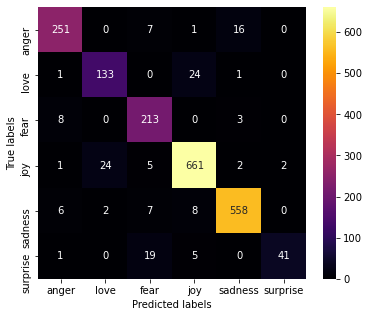

In [51]:
matrix = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix)

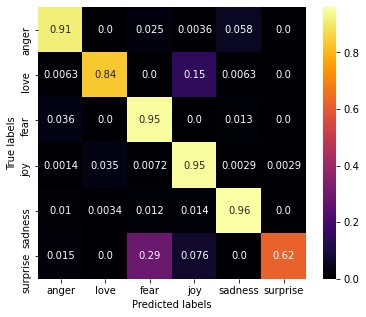

In [52]:
# create new confusion matrix
# where values are normed by row
matrix_new = np.zeros(matrix.shape)

for row in range(len(matrix)):
    sum = np.sum(matrix[row])
    for element in range(len(matrix[row])):
        matrix_new[row][element] = matrix[row][element] / sum

plot_confusion_matrix(matrix_new, fmt='.2')

## Test On Custom Data

In [53]:
def predict(texts):
    texts_prepr = [text_preprocess(t) for t in texts]
    sequences = tokenizer.texts_to_sequences(texts_prepr)
    pad = pad_sequences(sequences, maxlen=MAX_LEN)

    predictions = model.predict(pad)
    labels = np.argmax(predictions, axis=1)
  
    for i, lbl in enumerate(labels):
        print(f'\'{texts[i]}\' --> {labels_to_emotions[lbl]}')

In [55]:
labels_to_emotions = {j:i for i,j in emotions_to_labels.items()}

In [56]:
test_texts = ['I am so happy', 'The man felt lonely', 'The guests felt satisfied']

predict(test_texts)

'I am so happy' --> joy
'The man felt lonely' --> sadness
'The guests felt satisfied' --> joy


In [58]:
model.save('my_model.h5')